# Batch Correction

In this notebook, we will work with multiple samples, and discuss batch effect issues.

# Load packages

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

# Loading multiple samples into Scanpy

All of the computation we have done so far has been on a single sample. However, most real world data are likely not going to be a single sample and often require us to merge multiple data. We will use Scanpy to concatenate multiple data into one unified anndata object and discuss the issue of technical effect and its correction.

For the purposes of illustration we will use the PBMC data (dataset 5) used in this publication: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1850-9. The authors provide the data in an easily usable format (https://github.com/JinmiaoChenLab/Batch-effect-removal-benchmarking).

⚠️ Adjust the variable below to the data path on your specific workstation.

In [2]:
data_path = "./data_day1/"

## batch-1

In [3]:
data_batch1 = pd.read_csv(data_path + "b1_exprs.txt", sep="\t", index_col=0)
celltype_batch1 = pd.read_csv(data_path + "b1_celltype.txt", sep="\t", index_col=0)

In [4]:
data_batch1.head()

,data_3p-AAACCTGAGCATCATC-0,data_3p-AAACCTGAGCTAGTGG-0,data_3p-AAACCTGCACATTAGC-0,data_3p-AAACCTGCACTGTTAG-0,data_3p-AAACCTGCATAGTAAG-0,data_3p-AAACCTGCATGAACCT-0,data_3p-AAACCTGGTAAGAGGA-0,data_3p-AAACCTGGTAGAAGGA-0,data_3p-AAACCTGGTCCAGTGC-0,data_3p-AAACCTGGTGTCTGAT-0,...,data_3p-TTTGTCACAGGGATTG-0,data_3p-TTTGTCAGTAGCAAAT-0,data_3p-TTTGTCAGTCAGATAA-0,data_3p-TTTGTCAGTCGCGTGT-0,data_3p-TTTGTCAGTTACCGAT-0,data_3p-TTTGTCATCATGTCCC-0,data_3p-TTTGTCATCCGATATG-0,data_3p-TTTGTCATCGTCTGAA-0,data_3p-TTTGTCATCTCGAGTA-0,data_3p-TTTGTCATCTGCTTGC-0
RP11-34P13.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RP11-34P13.7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RP11-34P13.8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We see above that the rows are genes and the columns are cells. We will have to keep this in mind when we create an anndata object out of the data.

Let's create an anndata object for batch1:

In [5]:
# Notes:
# We transpose the data to ensure rows are cells and columns are genes
# We consider columns of the dataframe above as the cell names
# We consider rows of the dataframe above as the gene names
adata1 = sc.AnnData(
    data_batch1.values.T,
    obs=pd.DataFrame(index=data_batch1.columns),
    var=pd.DataFrame(index=data_batch1.index),
)

In [6]:
adata1

AnnData object with n_obs × n_vars = 8098 × 33694

Add the author provided celltype information:

In [7]:
celltype_batch1

,Sample,n_counts,n_genes,batch,louvain,anno,Method,CellType
data_3p-AAACCTGAGCATCATC-0,data_3p,2394,871,0,9,B cell,10X_3prime,B cell
data_3p-AAACCTGAGCTAGTGG-0,data_3p,4520,1316,0,5,CD4 T cell,10X_3prime,CD4 T cell
data_3p-AAACCTGCACATTAGC-0,data_3p,2788,898,0,1,CD4 T cell,10X_3prime,CD4 T cell
data_3p-AAACCTGCACTGTTAG-0,data_3p,4667,1526,0,0,Monocyte_CD14,10X_3prime,Monocyte_CD14
data_3p-AAACCTGCATAGTAAG-0,data_3p,4440,1495,0,0,Monocyte_CD14,10X_3prime,Monocyte_CD14
...,...,...,...,...,...,...,...,...
data_3p-TTTGTCATCATGTCCC-0,data_3p,3141,1176,0,4,CD8 T cell,10X_3prime,CD8 T cell
data_3p-TTTGTCATCCGATATG-0,data_3p,5401,1379,0,4,CD8 T cell,10X_3prime,CD8 T cell
data_3p-TTTGTCATCGTCTGAA-0,data_3p,6081,1802,0,0,Monocyte_CD14,10X_3prime,Monocyte_CD14
data_3p-TTTGTCATCTCGAGTA-0,data_3p,3970,1317,0,7,CD8 T cell,10X_3prime,CD8 T cell


In [8]:
for item in celltype_batch1.columns:
    adata1.obs[item] = celltype_batch1.loc[adata1.obs_names][item]

In [9]:
adata1

AnnData object with n_obs × n_vars = 8098 × 33694
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType'

## batch-2

In [10]:
data_batch2 = pd.read_csv(data_path + "b2_exprs.txt", sep="\t", index_col=0)
celltype_batch2 = pd.read_csv(data_path + "b2_celltype.txt", sep="\t", index_col=0)

In [11]:
data_batch2.head()

,data_5p-AAACCTGAGCGATAGC-1,data_5p-AAACCTGAGCTAAACA-1,data_5p-AAACCTGAGGGAGTAA-1,data_5p-AAACCTGAGTCTTGCA-1,data_5p-AAACCTGAGTTCGATC-1,data_5p-AAACCTGCACACTGCG-1,data_5p-AAACCTGCACGGTGTC-1,data_5p-AAACCTGCAGATGGGT-1,data_5p-AAACCTGCAGGTGGAT-1,data_5p-AAACCTGGTAAGCACG-1,...,data_5p-TTTGTCACAGCTGGCT-1,data_5p-TTTGTCACAGGTGGAT-1,data_5p-TTTGTCAGTCCGAAGA-1,data_5p-TTTGTCAGTTGATTGC-1,data_5p-TTTGTCATCACAAACC-1,data_5p-TTTGTCATCCACGTTC-1,data_5p-TTTGTCATCGCGTAGC-1,data_5p-TTTGTCATCTTAACCT-1,data_5p-TTTGTCATCTTACCGC-1,data_5p-TTTGTCATCTTGTTTG-1
RP11-34P13.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RP11-34P13.7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RP11-34P13.8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Similar to batch-1, we see above that the rows are genes and the columns are cells. We will have to keep this in mind when we create an anndata object out of the data.

Let's create an anndata object for batch-2:

In [12]:
# Notes:
# We transpose the data to ensure rows are cells and columns are genes
# We consider columns of the dataframe above as the cell names
# We consider rows of the dataframe above as the gene names
adata2 = sc.AnnData(
    data_batch2.values.T,
    obs=pd.DataFrame(index=data_batch2.columns),
    var=pd.DataFrame(index=data_batch2.index),
)

In [13]:
adata2

AnnData object with n_obs × n_vars = 7378 × 33694

Add the author provided celltype information:

In [14]:
celltype_batch2

,Sample,n_counts,n_genes,batch,louvain,anno,Method,CellType
data_5p-AAACCTGAGCGATAGC-1,data_5p,2712,1318,1,18,NK cell,10X_5prime,NK cell
data_5p-AAACCTGAGCTAAACA-1,data_5p,6561,2164,1,3,Monocyte_CD14,10X_5prime,Monocyte_CD14
data_5p-AAACCTGAGGGAGTAA-1,data_5p,6322,2112,1,8,Monocyte_CD14,10X_5prime,Monocyte_CD14
data_5p-AAACCTGAGTCTTGCA-1,data_5p,4528,1526,1,16,CD8 T cell,10X_5prime,CD8 T cell
data_5p-AAACCTGAGTTCGATC-1,data_5p,3426,1332,1,3,Monocyte_CD14,10X_5prime,Monocyte_CD14
...,...,...,...,...,...,...,...,...
data_5p-TTTGTCATCCACGTTC-1,data_5p,6547,2044,1,3,Monocyte_CD14,10X_5prime,Monocyte_CD14
data_5p-TTTGTCATCGCGTAGC-1,data_5p,3615,1397,1,10,B cell,10X_5prime,B cell
data_5p-TTTGTCATCTTAACCT-1,data_5p,3828,1480,1,16,CD8 T cell,10X_5prime,CD8 T cell
data_5p-TTTGTCATCTTACCGC-1,data_5p,6444,2388,1,28,Plasmacytoid dendritic cell,10X_5prime,Plasmacytoid dendritic cell


In [15]:
for item in celltype_batch2.columns:
    adata2.obs[item] = celltype_batch2.loc[adata2.obs_names][item]

In [16]:
adata2

AnnData object with n_obs × n_vars = 7378 × 33694
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType'

## Concatenate

Now that we have loaded data from both the batches, we can combine them to create one anndata object.

For details on the parameters used for the function below, please see: https://anndata.readthedocs.io/en/latest/generated/anndata.concat.html

For discussion/examples of concatenation, please see:
https://anndata.readthedocs.io/en/latest/concatenation.html 

Special Note: Please pay attention to `join = 'outer'` parameter. We are choosing to consider any gene that is expressed in either of the data. This means there may be some genes that are expressed in one data set but not in the other. What expression counts do these genes get in cells where they are not expressed? It depends on the input data matrix: if it is in sparse format they get 0, else NaN. So to ensure no NaN, we set `fill_value = 0`.

In [17]:
import anndata

adata = anndata.concat(
    [adata1, adata2],
    axis=0,
    join="outer",
    label="batch_id",
    index_unique="-",
    fill_value=0,
)


# If you have more than 2 samples:
# adata = adata1_corr.concatenate(adata2_corr, adata3_corr, adata4_corr,
#                                axis = 0,
#                                join='outer',
#                                label='batch_id',
#                                index_unique='-',
#                                fill_value=0)

In [18]:
adata

AnnData object with n_obs × n_vars = 15476 × 33694
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id'

Below we see the `.obs['batch_id']` of the adata and see that the first batch is called "0" and the second batch is called "1".

In [19]:
adata.obs["batch_id"]

data_3p-AAACCTGAGCATCATC-0-0    0
data_3p-AAACCTGAGCTAGTGG-0-0    0
data_3p-AAACCTGCACATTAGC-0-0    0
data_3p-AAACCTGCACTGTTAG-0-0    0
data_3p-AAACCTGCATAGTAAG-0-0    0
                               ..
data_5p-TTTGTCATCCACGTTC-1-1    1
data_5p-TTTGTCATCGCGTAGC-1-1    1
data_5p-TTTGTCATCTTAACCT-1-1    1
data_5p-TTTGTCATCTTACCGC-1-1    1
data_5p-TTTGTCATCTTGTTTG-1-1    1
Name: batch_id, Length: 15476, dtype: category
Categories (2, object): ['0', '1']

In [20]:
adata.X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [21]:
# check for NaN:
np.sum(np.isnan(adata.X))

np.int64(0)

As seen above, there are no NaN in the combined data, so we can proceed normally.

## Basic QC and normalization

In [22]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

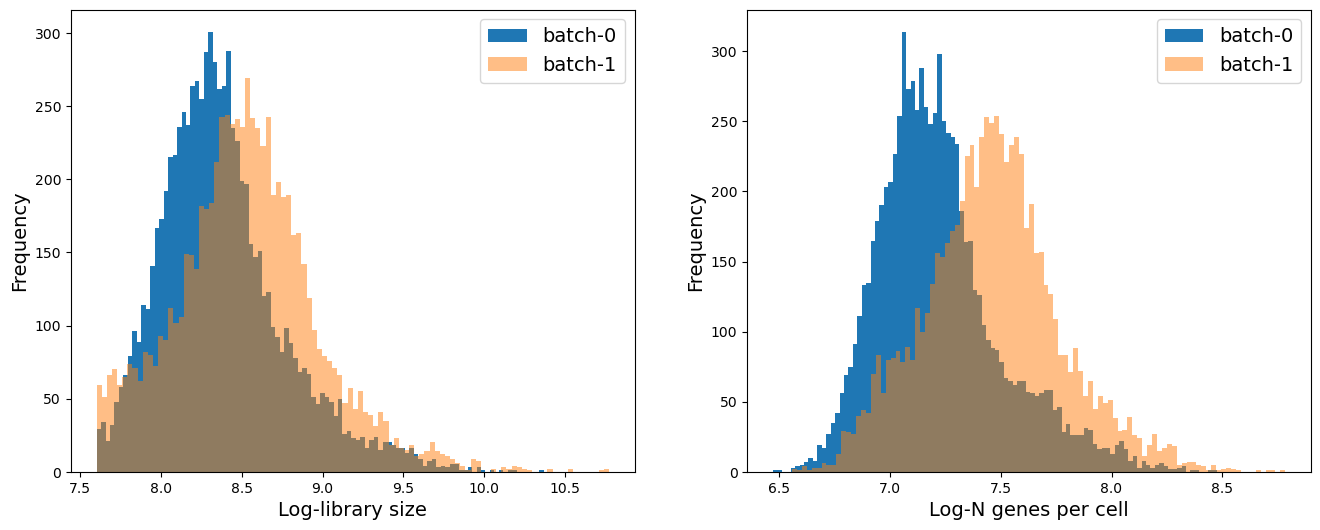

In [23]:
# Distribution of library size (total counts); number of genes per cell
fig = plt.figure(figsize=(8 * 2, 6 * 1))
ax = fig.add_subplot(1, 2, 1)
ax.hist(
    adata.obs["log1p_total_counts"][adata.obs["batch_id"] == "0"], 100, label="batch-0"
)
ax.hist(
    adata.obs["log1p_total_counts"][adata.obs["batch_id"] == "1"],
    100,
    label="batch-1",
    alpha=0.5,
)
ax.set_xlabel("Log-library size", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.legend(fontsize=14)

ax = fig.add_subplot(1, 2, 2)
ax.hist(
    adata.obs["log1p_n_genes_by_counts"][adata.obs["batch_id"] == "0"],
    100,
    label="batch-0",
)
ax.hist(
    adata.obs["log1p_n_genes_by_counts"][adata.obs["batch_id"] == "1"],
    100,
    label="batch-1",
    alpha=0.5,
)
ax.set_xlabel("Log-N genes per cell", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.legend(fontsize=14)

If you have more than 2 batch, you can run a for loop to visualize the distribution of each batch compared to the whole data. For this, you can adapt the following example code:

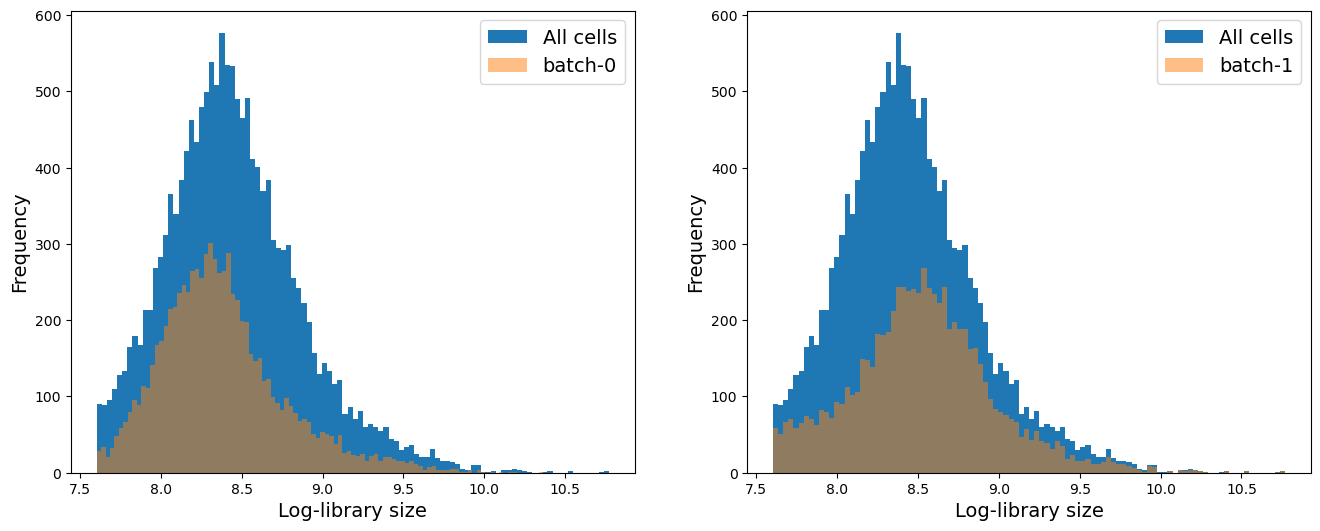

In [24]:
# Distribution of library size (total counts)
fig = plt.figure(figsize=(8 * 2, 6 * 1))
for j, item in enumerate(np.unique(adata.obs["batch_id"])):
    ax = fig.add_subplot(1, 2, j + 1)
    ax.hist(adata.obs["log1p_total_counts"], 100, label="All cells")
    ax.hist(
        adata.obs["log1p_total_counts"][adata.obs["batch_id"] == item],
        100,
        label="batch-" + item,
        alpha=0.5,
    )
    ax.set_xlabel("Log-library size", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.legend(fontsize=14)

We see that on average batch-1 cells have higher library size and higher number of genes expressed per cell. We will keep this mind as we analyze the data.

(0.0, 500.0)

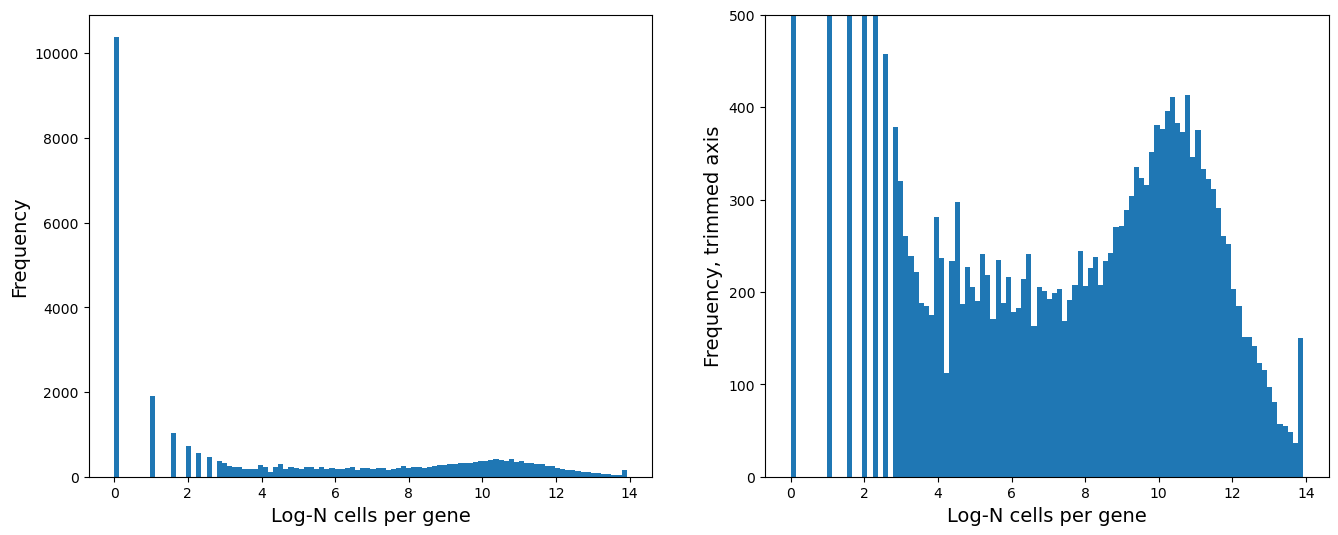

In [25]:
# Distribution of number of genes a cell is expressed in
fig = plt.figure(figsize=(8 * 2, 6 * 1))
ax = fig.add_subplot(1, 2, 1)
ax.hist(np.log2(adata.var["n_cells_by_counts"] + 1), 100)
ax.set_xlabel("Log-N cells per gene", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)

ax = fig.add_subplot(1, 2, 2)
ax.hist(np.log2(adata.var["n_cells_by_counts"] + 1), 100)
ax.set_xlabel("Log-N cells per gene", fontsize=14)
ax.set_ylabel("Frequency, trimmed axis", fontsize=14)
ax.set_ylim([0, 500])

In [26]:
# Remove genes expressed in less than 64 cells:
sc.pp.filter_genes(adata, min_cells=2**6)

In [27]:
adata

AnnData object with n_obs × n_vars = 15476 × 13386
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

In [28]:
# Normalizing + log transformation

# Store raw counts for future
adata.layers["raw_counts"] = adata.X.copy()

# Normalize with median library size
sc.pp.normalize_total(adata, inplace=True)

# Store the normalized counts for future
adata.layers["norm_counts"] = adata.X.copy()

# Take log2 of the normalized counts
adata.X = np.log2(adata.X + 1)

In [29]:
adata

AnnData object with n_obs × n_vars = 15476 × 13386
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'raw_counts', 'norm_counts'

## Highly variable genes, PCA, Nearest Neighbor Graph, UMAP

In [30]:
# HVG
sc.pp.highly_variable_genes(adata, n_top_genes=4000)
adata.uns["id_hvg"] = np.where(adata.var["highly_variable"])[0]

In [31]:
# PCA
sc.tl.pca(adata, n_comps=100, use_highly_variable=None)

Text(0, 0.5, '% Variance Explained')

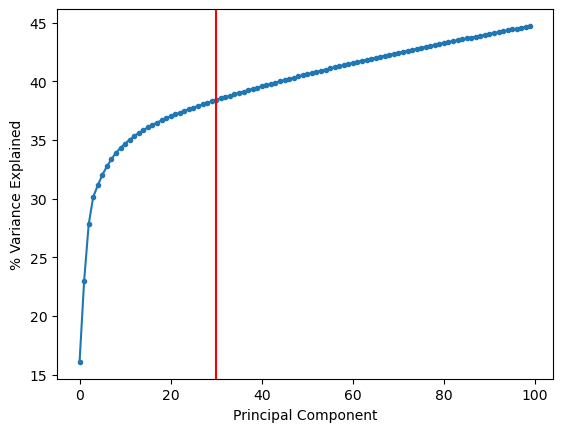

In [32]:
plt.plot(
    range(len(adata.uns["pca"]["variance_ratio"])),
    np.cumsum(adata.uns["pca"]["variance_ratio"]) * 100,
    ".-",
)
plt.axvline(30, color="r")
plt.xlabel("Principal Component")
plt.ylabel("% Variance Explained")

Based on the plot above, we will select 30 principal components.

In [33]:
adata.obsm["X_pca"] = adata.obsm["X_pca"][:, 0:30]

In [34]:
# Nearest neighbors on PCA
sc.pp.neighbors(
    adata, n_neighbors=30, use_rep="X_pca", metric="euclidean", key_added="neighbors_30"
)

/Users/tim.treis/anaconda3/envs/spatialdata/envs/workshop_2025/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
# UMAP using the nearest neighbors
sc.tl.umap(adata, neighbors_key="neighbors_30", min_dist=0.1)

In [36]:
# Clustering using leiden
sc.tl.leiden(adata, resolution=0.5, neighbors_key="neighbors_30")

/var/folders/qg/qgc908995g3fc8qtss2fsbhhxyxxj4/T/ipykernel_16241/3585288984.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 0.5, neighbors_key = 'neighbors_30')


In [37]:
adata

AnnData object with n_obs × n_vars = 15476 × 13386
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'id_hvg', 'pca', 'neighbors_30', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'norm_counts'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities'

## Visualize the results

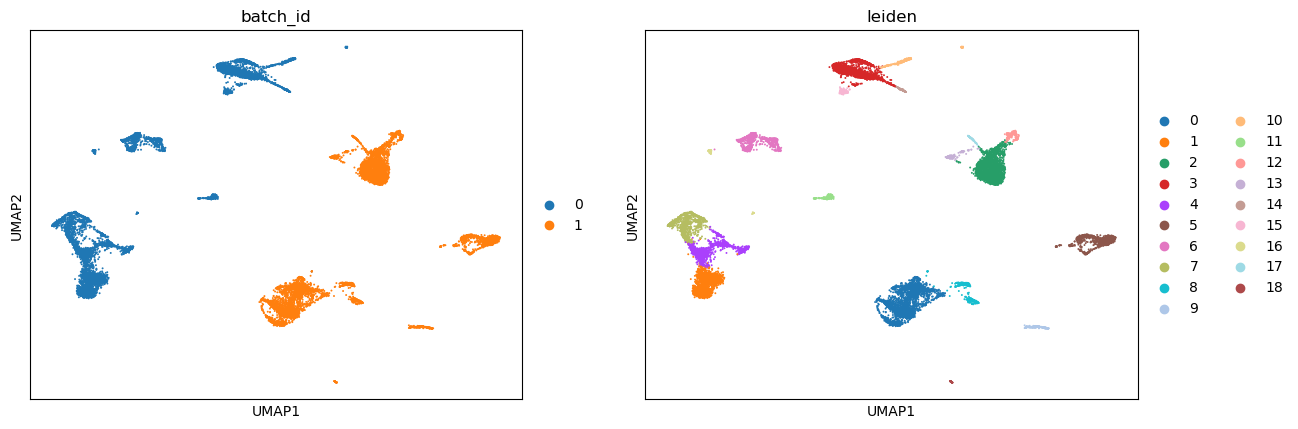

In [38]:
sc.pl.umap(adata, color=["batch_id", "leiden"])

## Visualize some genes

In [39]:
genes = [
    "CD3E",
    "CD8A",
    "CD4",
    "IL7R",
    "MS4A1",
    "CD19",
    "LYZ",
    "FCGR3A",
    "NKG7",
    "CST3",
    "PPBP",
    "PTPRC",
]

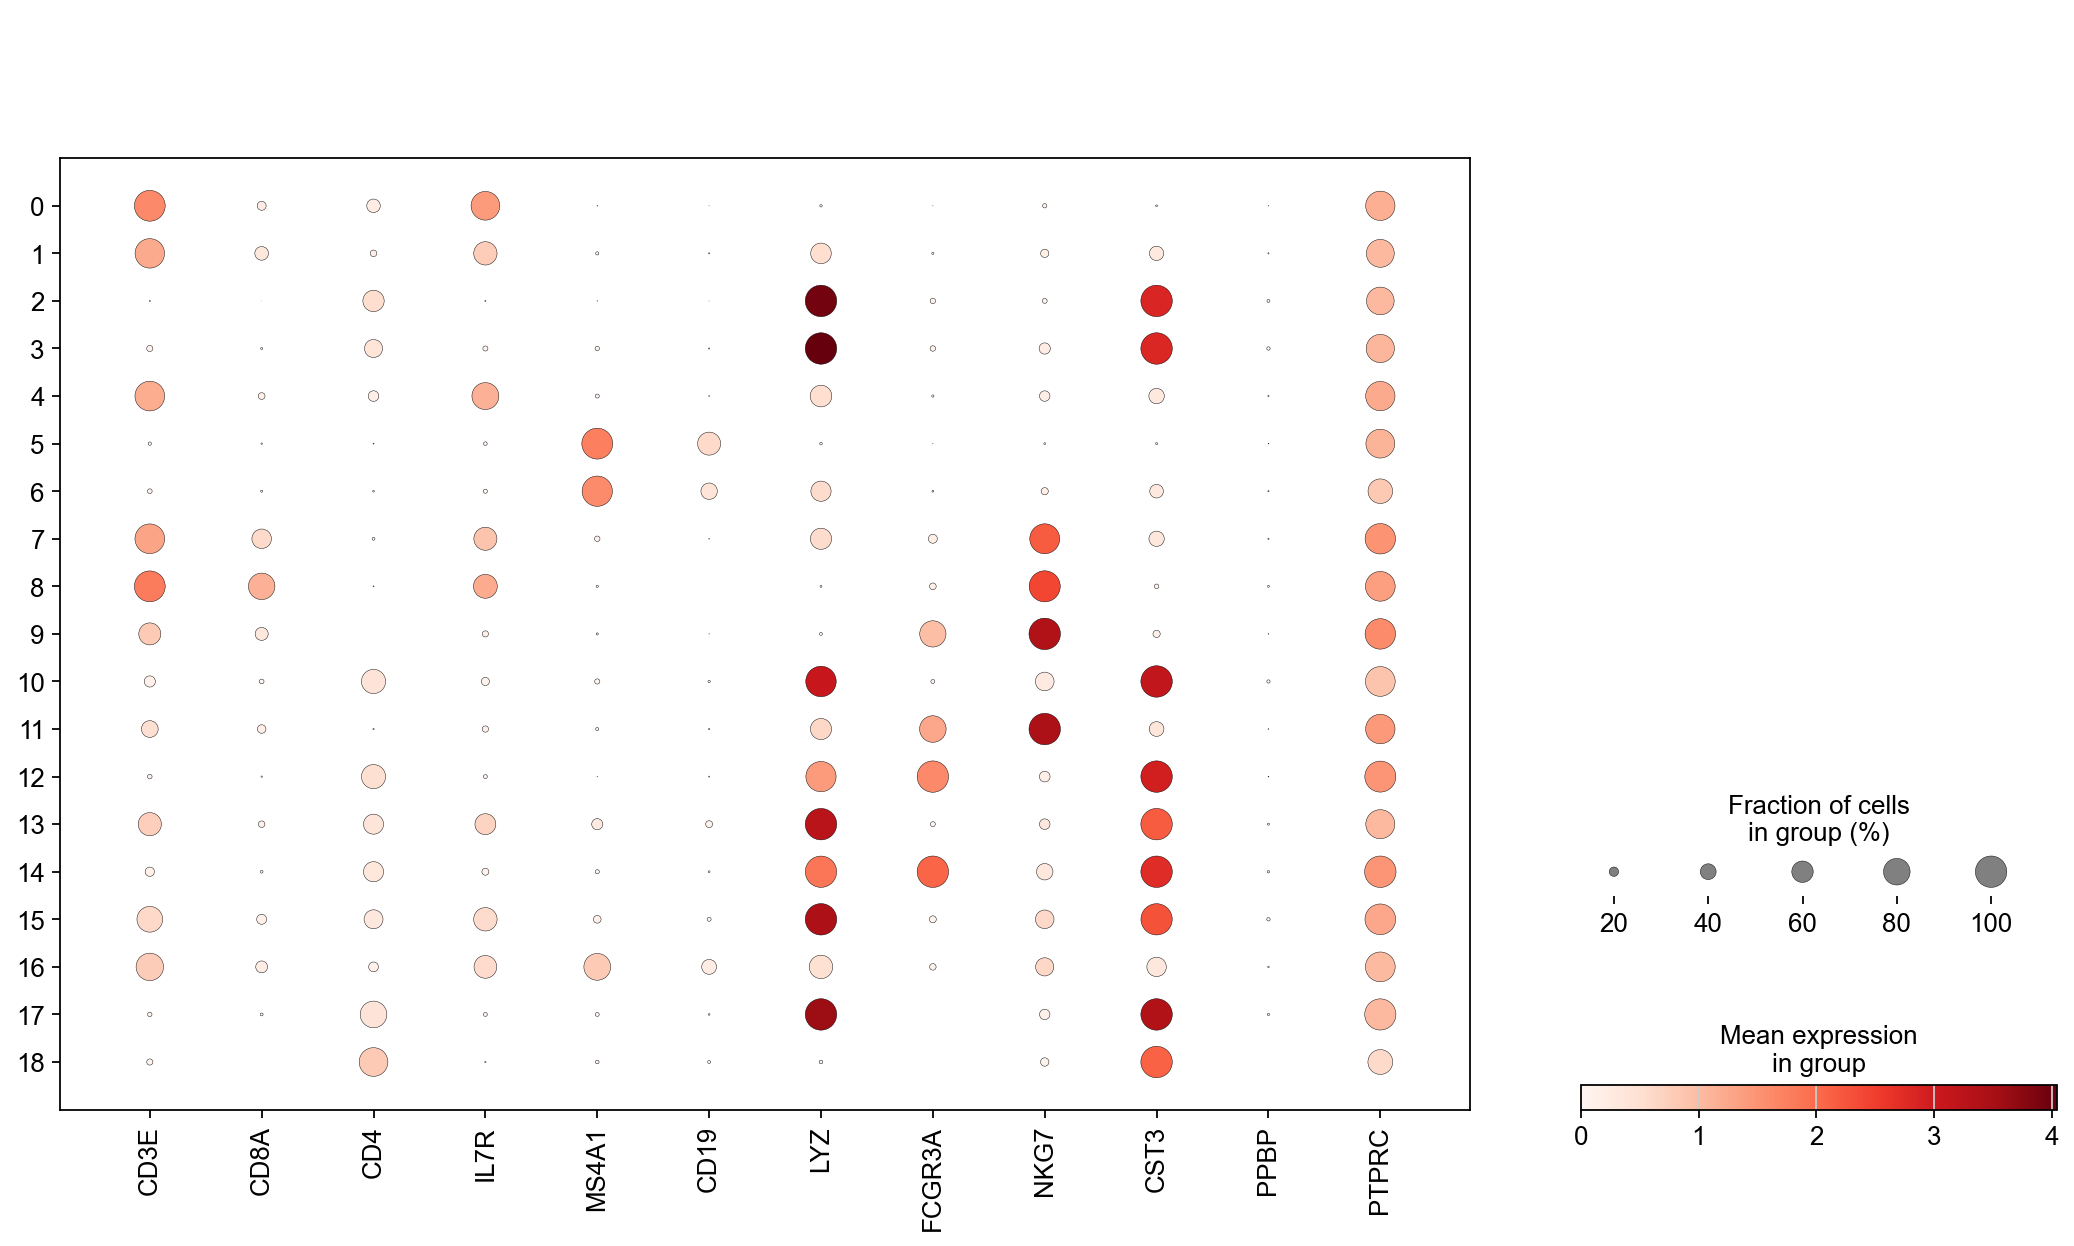

In [40]:
sc.set_figure_params(scanpy=True, fontsize=14)

fig = plt.figure(figsize=(8 * 2, 6 * 1.5))
ax1 = fig.add_subplot(1, 1, 1)
ac = sc.pl.dotplot(
    adata, genes, groupby="leiden", log=True, layer="norm_counts", show=False, ax=ax1
)

# Batch Effect Correction

Batch effect is a technical effect that can confound biological interpretations. We mostly design experiments in such a way that there is as little batch effect as possible. But often times, we wish to compare our data at hand against some other published data. It is natural to expect some batch effect in such cases. Therefore, we need to find computational solutions to correct such technical confounder. As such, this is one of the busiest areas for computational methods development. 

While there exists many methods to perform such correction, there is a common underlying assumption in all the methods: there must be some sub-populations with the same phenotype (cell type or state) across batches. Under this assumption, a majority of the methods begin by computing nearest neighbor cell or mutually nearest neighbor (MNN) between batches to identify the similar cells. While we have covered nearest neighbor cell in the previous sessions, we have not discussed mutually nearest neighbor cells. We define mutually nearest neighbor cells as follows: If a pair of cells from each batch is contained in each other's set of nearest neighbors, those cells are considered to be mutual nearest neighbors. The methods interpret these pairs as consisting cells that belong to the same cell type or state despite being generated in different batches.

Here, we will discuss some of the most popular methods for batch effect correction.

Scanorama: https://github.com/brianhie/scanorama
- Scanorama uses randomized singular value decomposition (SVD) - similar to PCA - to compress the gene expression profiles into a low-dimensional embedding.
- It then searches for MNNs in the dimensionality reduced spaces and uses them in a careful way (weighted by similarity) to guide batch integration.
- Note: Scanorama also corrects the expression of the genes in all the batches (i.e. outputs a batch corrected gene expression matrix) that can be utilized downstream for further analysis such as visualization, differential expression etc.

FastMNN: 
- FastMNN uses principal component analysis (PCA) to compress the gene expression profiles into a low-dimensional embedding.
- It then searches for MNNs in the dimensionality reduced spaces and uses them to compute a translation vector to align the datasets into a shared space.
- More details can be found here: https://marionilab.github.io/FurtherMNN2018/theory/description.html
- Note: The original version is `mnnCorrect`, but it is more computationally demanding in terms of CPU and memory as it uses the full high dimensional gene expression space. (https://rdrr.io/bioc/batchelor/man/mnnCorrect.html)
- Note: FastMNN also corrects the expression of the genes in all the batches (i.e. outputs a batch corrected gene expression matrix) that can be utilized downstream for further analysis such as visualization, differential expression etc.

Harmony: https://portals.broadinstitute.org/harmony/articles/quickstart.html
- Harmony uses Principal Component Analysis (PCA) to compress the gene expression profiles into a low-dimensional embedding.
-  In the PCA space, Harmony iteratively removes batch effects present. At each iteration, it clusters similar cells from different batches and maximizes the diversity of batches within each cluster. It then calculates a correction factor for each cell to be applied. It is good for visualization.
- Note: Harmony _does not_ correct the expression of the genes in all the batches.
- Note: Harmony has also been noted to mess up the structure of the data post-correction, so we recommend to use with caution and ensuring that biological interpretation remains consistent.

Seurat Integrate: https://satijalab.org/seurat/articles/integration_introduction.html
- Seurate Integrate uses canonical correlation analysis (CCA) to compress the gene expression profiles into a low-dimensional embedding.
- It then searches for MNNs in the dimensionally reduced spaces and uses them as "anchors" to guide batch correction.
- Note: Seurat Integrate _does not_ correct the expression of the genes in all the batches.

We provide example code to run four different batch correction methods.

# Batch effect correction - Scanorama

While Scanorama is integrated into Scanpy, the current implementation on Scanpy does not correct the gene expression matrix. Therefore we will use the original stand-alone implementation of Scanorama (i.e. we will not call the function via Scanpy).

In [41]:
!pip install scanorama

In [42]:
import scanorama

In [43]:
adata

AnnData object with n_obs × n_vars = 15476 × 13386
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'id_hvg', 'pca', 'neighbors_30', 'umap', 'leiden', 'batch_id_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'norm_counts'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities'

First, we need to divide the data into respective batches.

In [44]:
# Our batch variable is stored under 'batch'
batch_id = "batch"

adatas = []
for c in np.unique(adata.obs[batch_id]):
    idx = adata.obs[batch_id] == c
    adatas.append(adata[idx, :])

Now we can run Scanorama to obtain corrected expression counts.

In [45]:
corrected = scanorama.correct_scanpy(
    adatas, return_dimred=True, verbose=True, dimred=30, knn=30
)

Found 13386 genes among all datasets
Processing datasets (0, 1)


/Users/tim.treis/anaconda3/envs/spatialdata/envs/workshop_2025/lib/python3.10/site-packages/anndata/_core/anndata.py:787: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  getattr(self, attr).index = value
/Users/tim.treis/anaconda3/envs/spatialdata/envs/workshop_2025/lib/python3.10/site-packages/anndata/_core/anndata.py:787: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  getattr(self, attr).index = value


A note on the code above (you can also view the help page for scanorama):
1. The first input is a list of the adata, or batches we want to correct. Note: Scanorama directly acts on `.X`.
2. return_dimred = True implies that the method will return the reduced dimensions (like PCA) where the two batches have been co-embedded or co-aligned. 
3. verbose = True indicates whether to output the intermediate comments.
4. dimred = 30 is the number of dimensions on which Scanorama will perform the cell nearest neighbor mathching. I set it to 30 because based on our analysis above, we find that 30 principal components capture enough variance.
5. knn = 30 is the number of nearest neighbors to estimate. This number should be smaller if you know the size of your sub-populations that are shared across batches is smaller.

Note: There is another parameter called `hvg` to specify the number of highly variable genes (automatically estimated by scanorama), which we welcome you to play with. The only catch is that if you specify this number, the output matrix will only be corrected with highly varying genes (i.e. not all the genes).

The output is stored in `corrected` which stores output `anndata` as lists. For example, `corrected[0]` contains the corrected data for batch-0 and `corrected[1]` contains the corrected data for batch-1.

In [46]:
corrected[0]

AnnData object with n_obs × n_vars = 8098 × 13386
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'id_hvg', 'pca', 'neighbors_30', 'umap', 'leiden', 'batch_id_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'X_scanorama'

In [47]:
corrected[1]

AnnData object with n_obs × n_vars = 7378 × 13386
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'id_hvg', 'pca', 'neighbors_30', 'umap', 'leiden', 'batch_id_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'X_scanorama'

We can combine the results and create a new anndata called adata_corrected.

In [48]:
adata_corrected = anndata.concat(corrected)

In [49]:
adata_corrected

AnnData object with n_obs × n_vars = 15476 × 13386
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden'
    obsm: 'X_pca', 'X_umap', 'X_scanorama'

Note: In the above combined adata_corrected data, we have X_pca and X_umap, which were computed previously and should not used for the corrected combined data. So we need to recompute them. But first let's save them as something else so they don't overwritten.

In [50]:
adata_corrected.obsm["old_UMAP"] = adata_corrected.obsm["X_umap"]

In [51]:
data_path

'./data_day1/'

In [52]:
# Save for later:
adata_corrected.write_h5ad(data_path + "processed/batch_data_scanorama_corrected.h5ad")

##  Nearest neighbors and UMAP

Note: Corrected reduced dimensions - PCA analogous - have already been computed (they are stored in `.obsm['X_scanorama']`) so all we need to do is run nearest neighbors algorithm followed by UMAP for visualization.

In [53]:
# Nearest neighbors on corrected PCA
sc.pp.neighbors(
    adata_corrected,
    n_neighbors=30,
    use_rep="X_scanorama",
    metric="euclidean",
    key_added="neighbors_30_corrected",
)

In [54]:
# UMAP, FDL using the nearest neighbors
sc.tl.umap(adata_corrected, neighbors_key="neighbors_30_corrected", min_dist=0.1)

## Visualize

Text(0.5, 1.0, 'UMAP of un-corrected data')

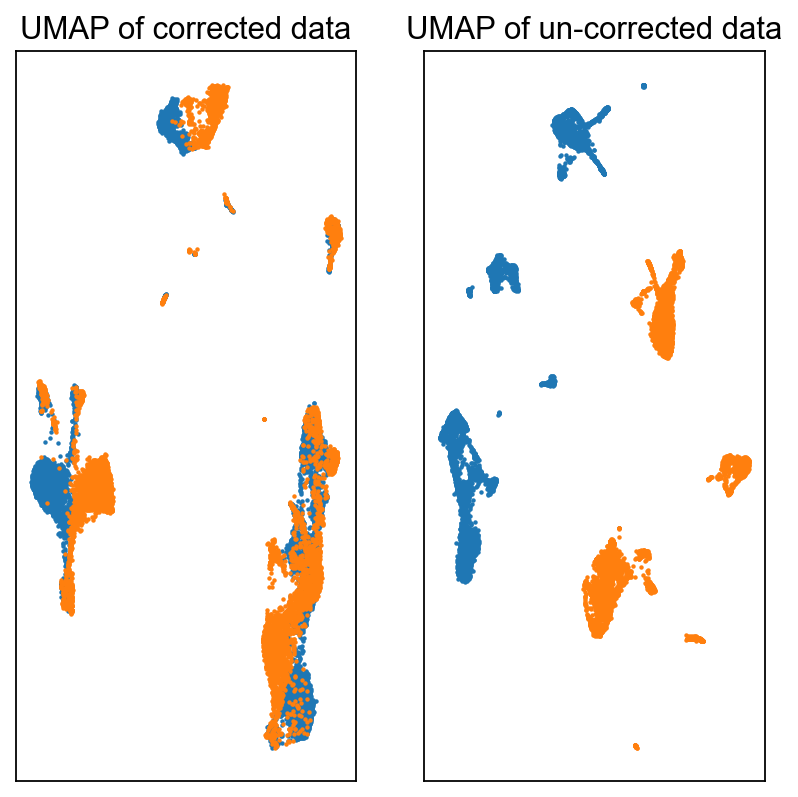

In [55]:
fig = plt.figure(figsize=(3 * 2, 3 * 2))
ax = fig.add_subplot(1, 2, 1)
c0 = adata_corrected.obs["batch"].astype(int) == 0
c1 = adata_corrected.obs["batch"].astype(int) == 1
ax.scatter(
    adata_corrected.obsm["X_umap"][c0, 0],
    adata_corrected.obsm["X_umap"][c0, 1],
    s=1,
    label="Batch-0",
)
ax.scatter(
    adata_corrected.obsm["X_umap"][c1, 0],
    adata_corrected.obsm["X_umap"][c1, 1],
    s=1,
    label="Batch-1",
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("UMAP of corrected data")

ax = fig.add_subplot(1, 2, 2)
c0 = adata.obs["batch"] == 0
c1 = adata.obs["batch"] == 1
ax.scatter(
    adata_corrected.obsm["old_UMAP"][c0, 0],
    adata_corrected.obsm["old_UMAP"][c0, 1],
    s=1,
    label="Batch-0",
)
ax.scatter(
    adata_corrected.obsm["old_UMAP"][c1, 0],
    adata_corrected.obsm["old_UMAP"][c1, 1],
    s=1,
    label="Batch-1",
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("UMAP of un-corrected data")

In [56]:
help(scanorama.correct)

Help on function correct in module scanorama.scanorama:

correct(datasets_full, genes_list, return_dimred=False, batch_size=5000, verbose=2, ds_names=None, dimred=100, approx=True, sigma=15, alpha=0.1, knn=20, return_dense=False, hvg=None, union=False, seed=0)
    Integrate and batch correct a list of data sets.
    
    Parameters
    ----------
    datasets_full : `list` of `scipy.sparse.csr_matrix` or of `numpy.ndarray`
        Data sets to integrate and correct.
    genes_list: `list` of `list` of `string`
        List of genes for each data set.
    return_dimred: `bool`, optional (default: `False`)
        In addition to returning batch corrected matrices, also returns
        integrated low-dimesional embeddings.
    batch_size: `int`, optional (default: `5000`)
        The batch size used in the alignment vector computation. Useful when
        correcting very large (>100k samples) data sets. Set to large value
        that runs within available memory.
    verbose: `bool` or `

## True celltypes

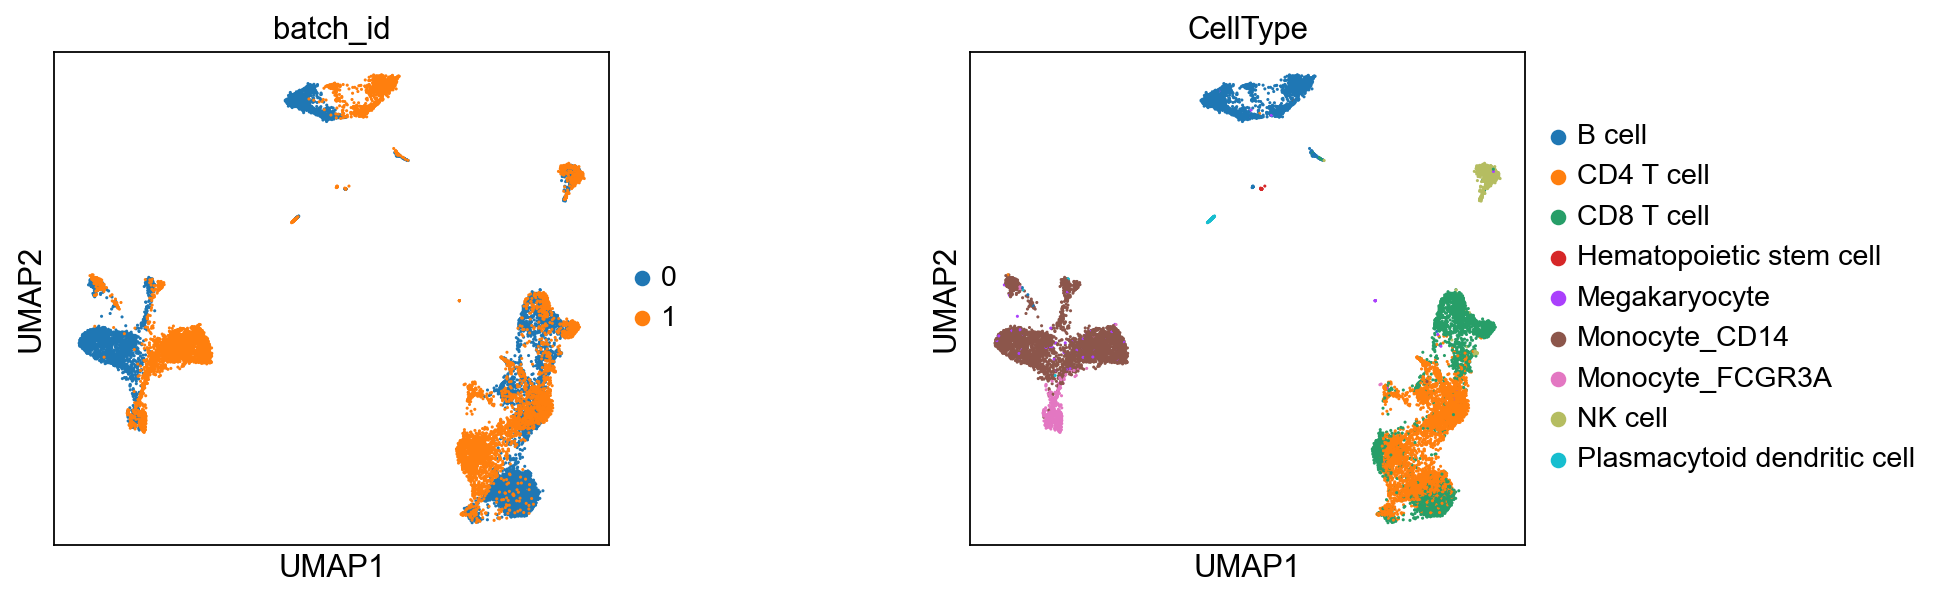

In [57]:
sc.pl.umap(adata_corrected, color=["batch_id", "CellType"], wspace=0.5)

# Batch effect correction - Harmony

Harmony is another popular method for correcting batch effect in single-cell RNA-sequencing data. As discussed in the beginning, Harmony iteratively removes batch effects in the PCA space. In each iteration, it clusters similar cells from different batches and maximizing the diversity of batches within each cluster; it then calculates a correction factor for each cell to be applied. While it is a fast method, there are a couple caveats: 1) Since it operates only on the PCA space, any non-linear association between features could be missed or altered; and 2) Harmony does not provide a corrected gene expression matrix. Therefore, the output of Harmony can only be used for visualization and clustering but not for differential expression analysis or any gene centric analysis, since one does not get a corrected expression matrix back. One would need to be careful to perform downstream analysis with Harmony.

Harmony is implemented in Scanpy: https://scanpy.readthedocs.io/en/stable/generated/scanpy.external.pp.harmony_integrate.html. 

Let's first make a copy of `adata` for application of Harmony. Note we do not simply do `adata_harmony = adata` but specify `adata_harmony = adata.copy()` because of the issue of mutable variables in Python. See more here: https://www.geeksforgeeks.org/mutable-vs-immutable-objects-in-python/

In [58]:
adata_harmony = adata.copy()

In [59]:
# Please run this step if we did not install harmonypy
!pip install harmonypy

In [60]:
sc.external.pp.harmony_integrate(
    adata_harmony, key="batch_id", basis="X_pca", adjusted_basis="X_pca_harmony"
)

2025-04-17 15:59:58,897 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-04-17 16:00:01,141 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-04-17 16:00:01,183 - harmonypy - INFO - Iteration 1 of 10
2025-04-17 16:00:02,599 - harmonypy - INFO - Iteration 2 of 10
2025-04-17 16:00:04,071 - harmonypy - INFO - Iteration 3 of 10
2025-04-17 16:00:05,472 - harmonypy - INFO - Iteration 4 of 10
2025-04-17 16:00:07,030 - harmonypy - INFO - Iteration 5 of 10
2025-04-17 16:00:08,542 - harmonypy - INFO - Iteration 6 of 10
2025-04-17 16:00:10,087 - harmonypy - INFO - Converged after 6 iterations


In [61]:
adata_harmony

AnnData object with n_obs × n_vars = 15476 × 13386
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'id_hvg', 'pca', 'neighbors_30', 'umap', 'leiden', 'batch_id_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    layers: 'raw_counts', 'norm_counts'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities'

Now we just need to recompute the neighbors and UMAP on the above computed X_pca_harmony:

In [62]:
# Save to prevent overwriting
adata_harmony.obsm["old_UMAP"] = adata_harmony.obsm["X_umap"]

In [63]:
# Nearest neighbors on PCA_harmony
sc.pp.neighbors(
    adata_harmony,
    n_neighbors=30,
    use_rep="X_pca_harmony",
    metric="euclidean",
    key_added="neighbors_30_harmony",
)

In [64]:
# UMAP using the nearest neighbors
sc.tl.umap(adata_harmony, neighbors_key="neighbors_30_harmony", min_dist=0.1)

Text(0.5, 1.0, 'UMAP of un-corrected data')

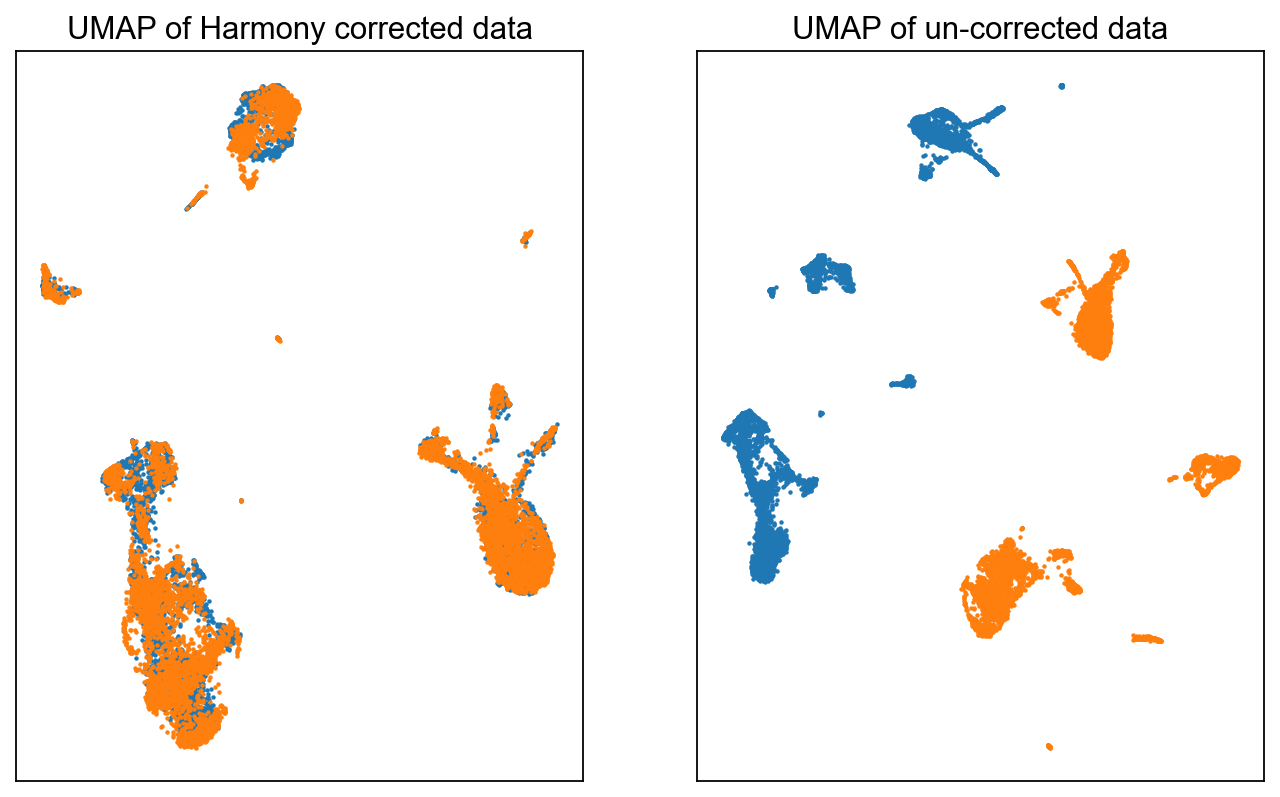

In [68]:
fig = plt.figure(figsize=(5 * 2, 3 * 2))
ax = fig.add_subplot(1, 2, 1)
c0 = adata_harmony.obs["batch"].astype(int) == 0
c1 = adata_harmony.obs["batch"].astype(int) == 1
ax.scatter(
    adata_harmony.obsm["X_umap"][c0, 0],
    adata_harmony.obsm["X_umap"][c0, 1],
    s=1,
    label="Batch-0",
)
ax.scatter(
    adata_harmony.obsm["X_umap"][c1, 0],
    adata_harmony.obsm["X_umap"][c1, 1],
    s=1,
    label="Batch-1",
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("UMAP of Harmony corrected data")

ax = fig.add_subplot(1, 2, 2)
c0 = adata.obs["batch"] == 0
c1 = adata.obs["batch"] == 1
ax.scatter(
    adata_harmony.obsm["old_UMAP"][c0, 0],
    adata_harmony.obsm["old_UMAP"][c0, 1],
    s=1,
    label="Batch-0",
)
ax.scatter(
    adata_harmony.obsm["old_UMAP"][c1, 0],
    adata_harmony.obsm["old_UMAP"][c1, 1],
    s=1,
    label="Batch-1",
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("UMAP of un-corrected data")

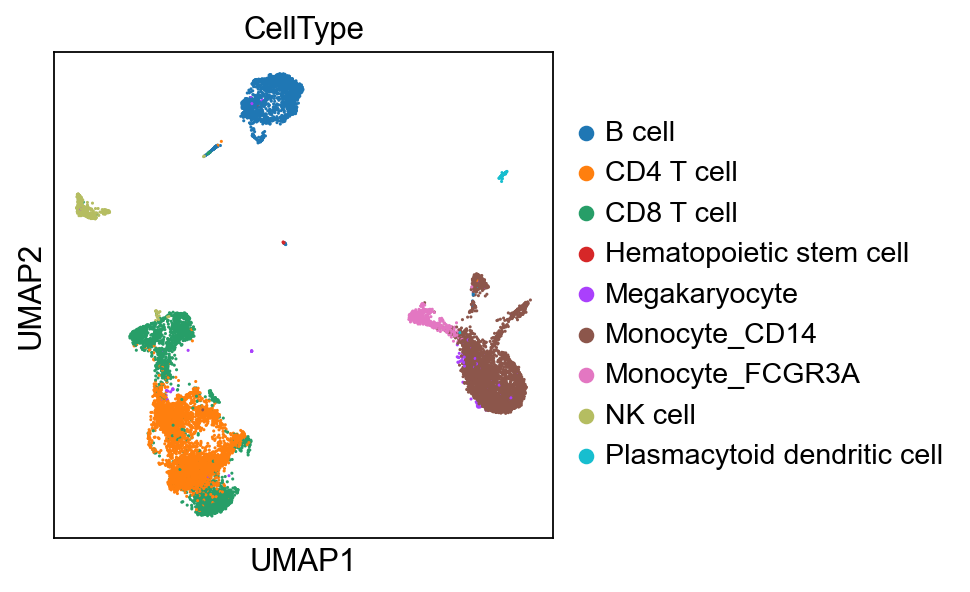

In [69]:
sc.pl.umap(adata_harmony, color=["CellType"])

## Compare integrations using scib-metrics
Integration is very much dataset dependent and there is no single tool that always performs best. Usually, it's better to use a few methods and evaluate their quality by certain downstrea metrics. One package that can facility this is `scib-metrics`.

In [70]:
# Please run this step if we did not install harmonypy
!pip install scib-metrics

  Using cached rich-14.0.0-py3-none-any.whl.metadata (18 kB)
  Using cached toolz-1.0.0-py3-none-any.whl.metadata (5.1 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
Using cached rich-14.0.0-py3-none-any.whl (243 kB)
Using cached markdown_it_py-3.0.0-py3-none-any.whl (87 kB)
Using cached mdurl-0.1.2-py3-none-any.whl (10.0 kB)


In [79]:
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection

We can see that both AnnData objects produced one embedding vector with 30 values for every cell.

In [73]:
adata_corrected.obsm["X_scanorama"].shape

(15476, 30)

In [74]:
adata_harmony.obsm["X_pca_harmony"].shape

(15476, 30)

We'll now create a joint AnnData object that we pass to scib-metrics for evaluation.

In [81]:
adata_for_scib = adata_corrected.copy()
adata_for_scib.obsm["Unintegrated"] = adata_corrected.obsm["X_pca"]
adata_for_scib.obsm["X_scanorama"] = adata_corrected.obsm["X_scanorama"]
adata_for_scib.obsm["X_pca_harmony"] = adata_harmony.obsm["X_pca_harmony"]
adata_for_scib.obs["batch"] = adata_corrected.obs["batch_id"]
adata_for_scib.obs["celltype"] = adata_corrected.obs["CellType"]

In [84]:
bm = Benchmarker(
    adata_for_scib,
    batch_key="batch",
    label_key="celltype",
    bio_conservation_metrics=BioConservation(),
    batch_correction_metrics=BatchCorrection(),
    embedding_obsm_keys=[
        "Unintegrated",
        "X_scanorama",
        "X_pca_harmony",
    ],
)
bm.benchmark()

/Users/tim.treis/anaconda3/envs/spatialdata/envs/workshop_2025/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:438: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]/Users/tim.treis/anaconda3/envs/spatialdata/envs/workshop_2025/lib/python3.10/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
/Users/tim.treis/anaconda3/envs/spatialdata/envs/workshop_2025/lib/python3.10/site-packages/scib_metrics/metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 

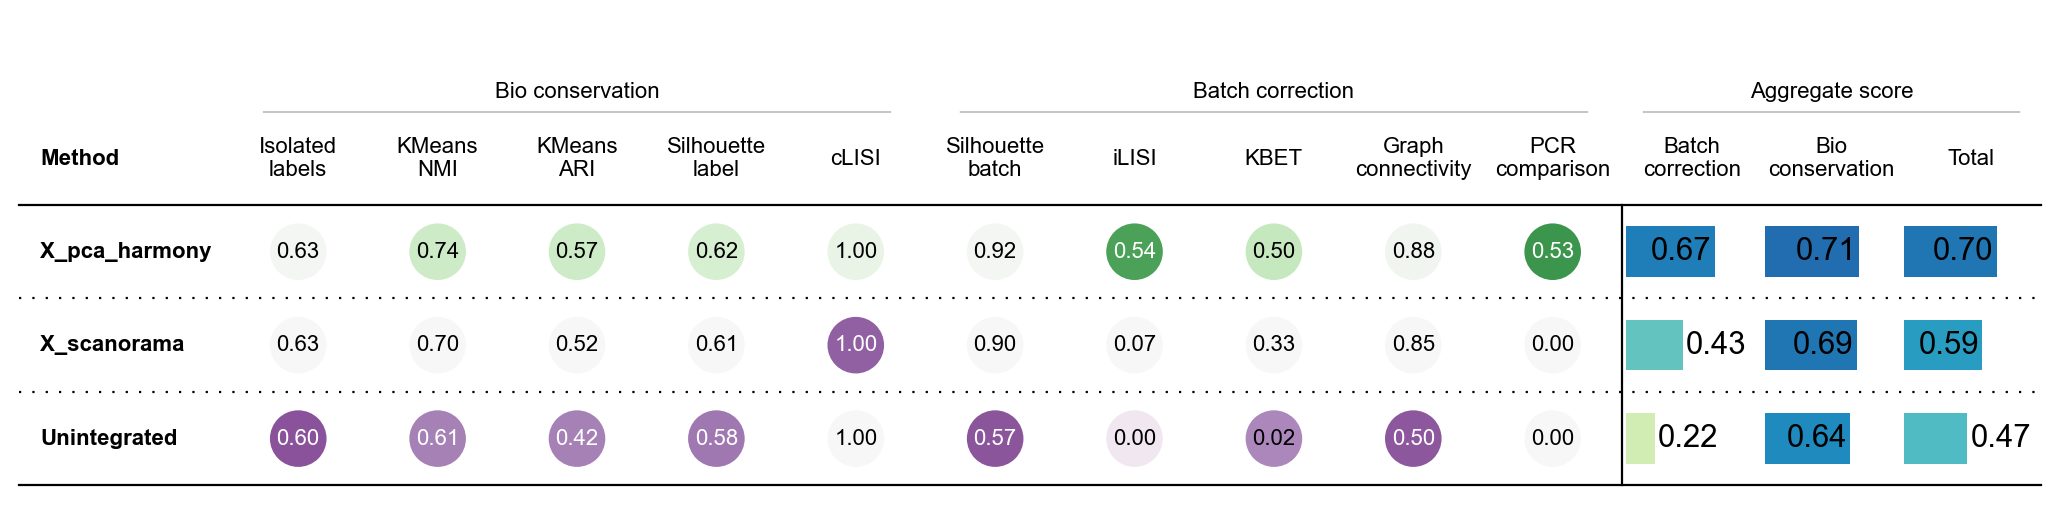

In [86]:
bm.plot_results_table(min_max_scale=False)

We can see that, based on the default `scib-metrics`, harmony seems to perform significantly better than `scanorama`. For more information on what these metrics exactly are or how best to understand them, please refer to the [official scib-metrics documentation.](https://scib-metrics.readthedocs.io/)